##  SMI: Stochastic Momentum Reversion
A mean-reversion strategy utilizing the Stochastic Momentum Index to identify and trade reversals from deep oversold territory.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
RANDOM_SEED = 2750
np.random.seed(RANDOM_SEED)


In [2]:
import sys
from pathlib import Path

sys.path.append("systrade")

In [3]:
config_base_path = "systrade"

In [4]:
from backtester.backtest_engine import *
from backtester.data_loader import *
from backtester.visualizations import *
from backtester.utils import *
from backtester.reports import *

In [5]:
from strategies.strategy_smi import * 
from visuals.plot_smi_signals import *

In [6]:
# dji_components = ["MMM", "AXP", "AMGN", "AMZN", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO", "DIS", "GS", "HD", "HON", "IBM", "JNJ", "JPM", "MCD", "MRK", "MSFT", "NKE", "NVDA", "PG", "CRM", "SHW", "TRV", "UNH", "VZ", "V", "WMT"]
dji_halfweight = ["GS", "MSFT", "HD", "V", "SHW", "CAT", "MCD", "UNH", "AXP"] #account for 50% of weighting

In [7]:
# Download market data
tickers = dji_halfweight

# Walk-Forward Analysis and Sensitivity Analysis

In [8]:
from backtester.walkforward_cv import *

In [9]:
set_random_seed(RANDOM_SEED)
data_dict = download_multiple(tickers,start_date='2017-04-01', end_date='2023-01-01')



  GS...  1448 bars
  MSFT...  1448 bars
  HD...  1448 bars
  V...  1448 bars
  SHW...  1448 bars
  CAT...  1448 bars
  MCD...  1448 bars
  UNH...  1448 bars
  AXP...  1448 bars
Successfully downloaded 9/9 tickers



In [10]:
trade_config = TradeConfig(
    initial_capital=300_000,
    position_size_pct=0.05,
    commission_pct=0.001,
    slippage_pct=0.0005,
    slippage_fixed=0.0,
    max_trade_size=30_000,        
    min_trade_size=10_000
)

wf_config = create_wf_config(
    training_days=252*2,
    testing_days=21*9,
    holdout_days=21*6,
    min_trades=30,
    n_trials=150,
    n_startup_trials = 50,
    n_jobs=-1,
    timeout=3600,
    random_seed=2570
)


In [11]:
def get_smi_param_space() -> dict:
    """
    Parameter search space for SMI Optimization.
    """
    return {
        'k_period': ('int', 8, 57),
        'd_period': ('int', 2, 7),
        'oversold_threshold': ('int', -60, -0),
        'overbought_threshold': ('int', 0, 60),
    }


[I 2026-01-15 06:53:56,107] A new study created in memory with name: SMIStrategy_global_cv


Global Walk-Forward: 3 windows from 2017-04-03 to 2022-12-30

Running Global Optimization on 3 windows...
Global Optimization Complete. Best Score: 1.1200
{'k_period': 41, 'd_period': 2, 'oversold_threshold': -57, 'overbought_threshold': 37}

--- Degradation Analysis ---
Avg Sharpe Degradation: -19.42% (Lower is better)
  < 10%: Very Robust
  > 50%: High Overfitting

--- Parameter Stability (Cluster Analysis) ---
              parameter     cv  range_ratio assessment
2    oversold_threshold  0.081        0.252  Excellent
0              k_period  0.090        0.293  Excellent
3  overbought_threshold  0.115        0.411       Good
1              d_period  0.213        1.000       Poor

--- Parameter Importance ---
              parameter  importance
0              k_period    0.441309
1    oversold_threshold    0.344115
2              d_period    0.156512
3  overbought_threshold    0.058064


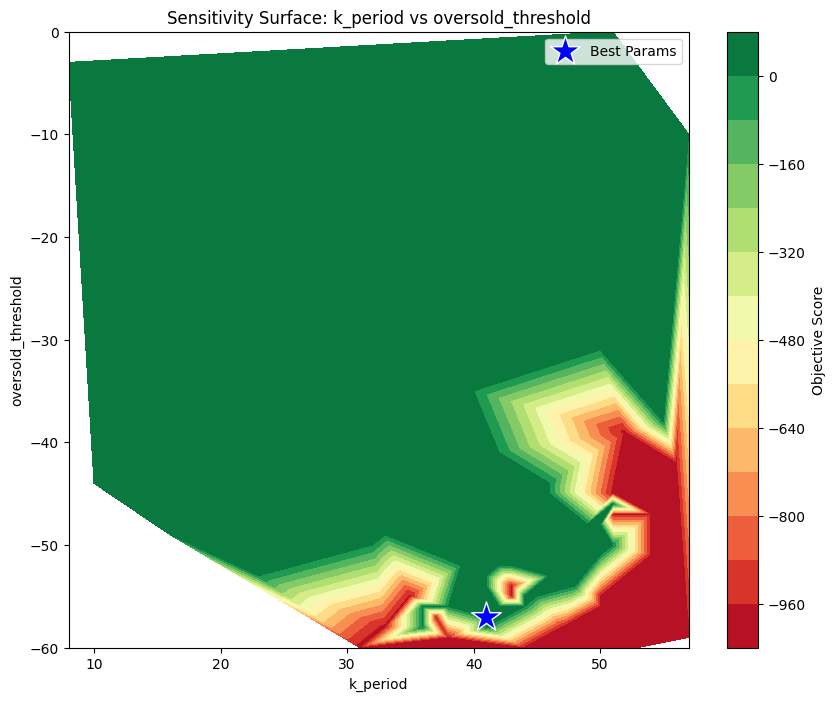

Results saved to wf_method2_results


In [12]:

param_space = get_smi_param_space()


results_df, sensitivity_df = run_walkforward(
    data_dict=data_dict,
    param_space=param_space,
    strategy_class=SMIStrategy,
    strategy_name="SMIStrategy",
    trade_config=trade_config,
    wf_config=wf_config,
    objective_weights=(0.35, 0.65),  # 35% win rate, 65% Sharpe
    verbose=True
)



# Backtest on Holdout Dataset 

In [13]:
start_date = '2023-01-01'
raw_data = download_multiple(tickers, start_date)


  GS...  761 bars
  MSFT...  761 bars
  HD...  761 bars
  V...  761 bars
  SHW...  761 bars
  CAT...  761 bars
  MCD...  761 bars
  UNH...  761 bars
  AXP...  761 bars
Successfully downloaded 9/9 tickers



In [14]:
# Load configurations
strategy_config, trade_config, full_config = load_configs(
    f'{config_base_path}/configs/smi_strategy.yaml',
    f'{config_base_path}/configs/default_settings.yaml'
)

In [15]:
strategy_config

StrategyConfig(name='SMI', parameters={'k_period': 40, 'd_period': 3, 'oversold_threshold': -50, 'overbought_threshold': 50})

In [16]:
trade_config

TradeConfig(initial_capital=100000, commission_pct=0.001, slippage_pct=0.0005, slippage_fixed=0.01, position_size_pct=0.95, max_trade_size=50000, min_trade_size=100)

In [17]:
trade_config.initial_capital = 300_000
trade_config.max_trade_size = 30_000
trade_config.min_trade_size = 10_000

In [18]:
trade_config

TradeConfig(initial_capital=300000, commission_pct=0.001, slippage_pct=0.0005, slippage_fixed=0.01, position_size_pct=0.95, max_trade_size=30000, min_trade_size=10000)

In [19]:
strategy_config.parameters = {'k_period': 49, 'd_period': 2, 'oversold_threshold': -57, 'overbought_threshold': 59}


In [20]:
aligned_data = align_data(raw_data)

print(f" Downloaded data for {len(tickers)} tickers")
if len(aligned_data) > 0:
    first_ticker = list(aligned_data.keys())[0]
    date_range = f"{aligned_data[first_ticker].index[0]} to {aligned_data[first_ticker].index[-1]}"
    print(f"   Date range: {date_range}")
    print(f"   Total bars per ticker: {len(aligned_data[first_ticker])}")

 Downloaded data for 9 tickers
   Date range: 2023-01-03 00:00:00 to 2026-01-14 00:00:00
   Total bars per ticker: 761


In [21]:
# Initialize strategy
print("\n Initializing SMI strategy...")
strategy = SMIStrategy(strategy_config)

# Validate configuration
if not strategy.validate_config():
    print(" Invalid configuration!")



 Initializing SMI strategy...


In [22]:
# Run backtest
print("\n Running backtest...")
engine = BacktestEngine(strategy, trade_config)
results = engine.run(aligned_data)

# Print results
print_performance_summary(results.metrics)



 Running backtest...

PERFORMANCE SUMMARY

*** RETURNS ***
  Initial Capital:    $  300,000.00
  Final Value:        $  368,356.84
  Total P&L:          $   68,356.84
  Total Return:              22.79%

*** RISK METRICS ***
  Sharpe Ratio:               1.06
  Sortino Ratio:              1.41
  Max Drawdown:              -7.62%
  Calmar Ratio:               2.99
  Annual Volatility:          6.61%

*** TRADE STATISTICS ***
  Total Trades:                 39
  Win Rate:                  84.62%
  Profit Factor:              7.89
  Expectancy:         $     1776.94
  Best Trade:         $     7929.28
  Worst Trade:        $    -4016.17
  Average Trade:      $     1776.94

*** COSTS ***
  Total Commission:   $        0.00
  Total Slippage:     $        0.00
  Total Costs:        $        0.00




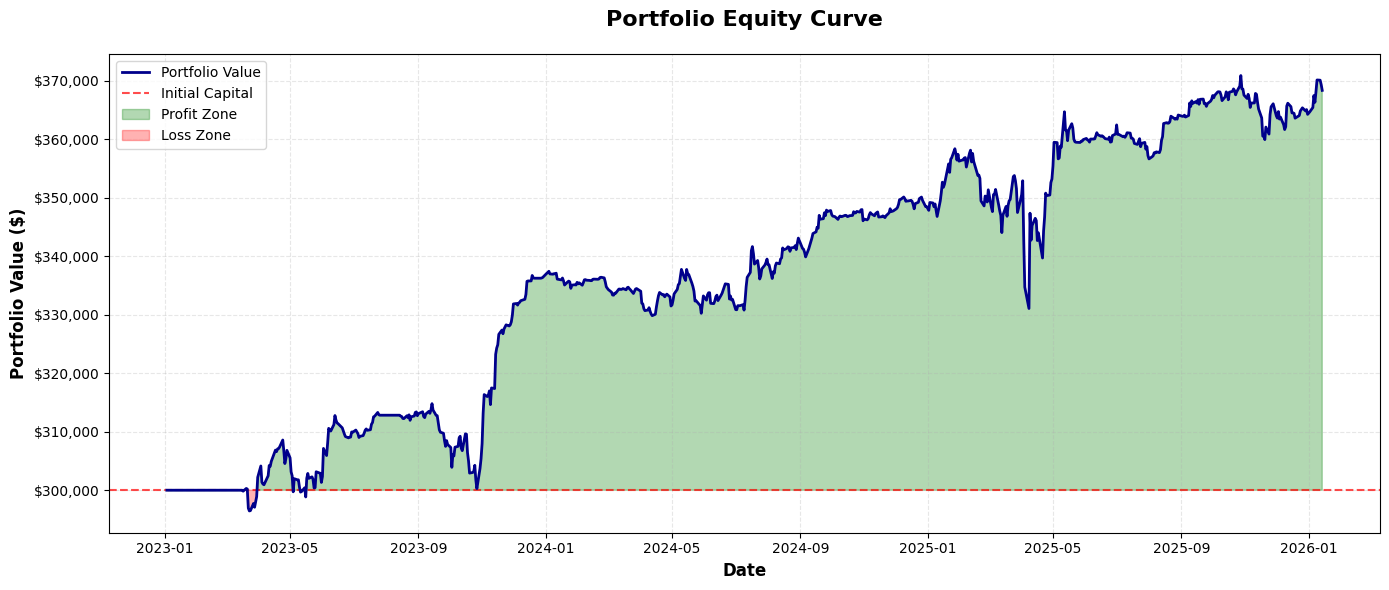

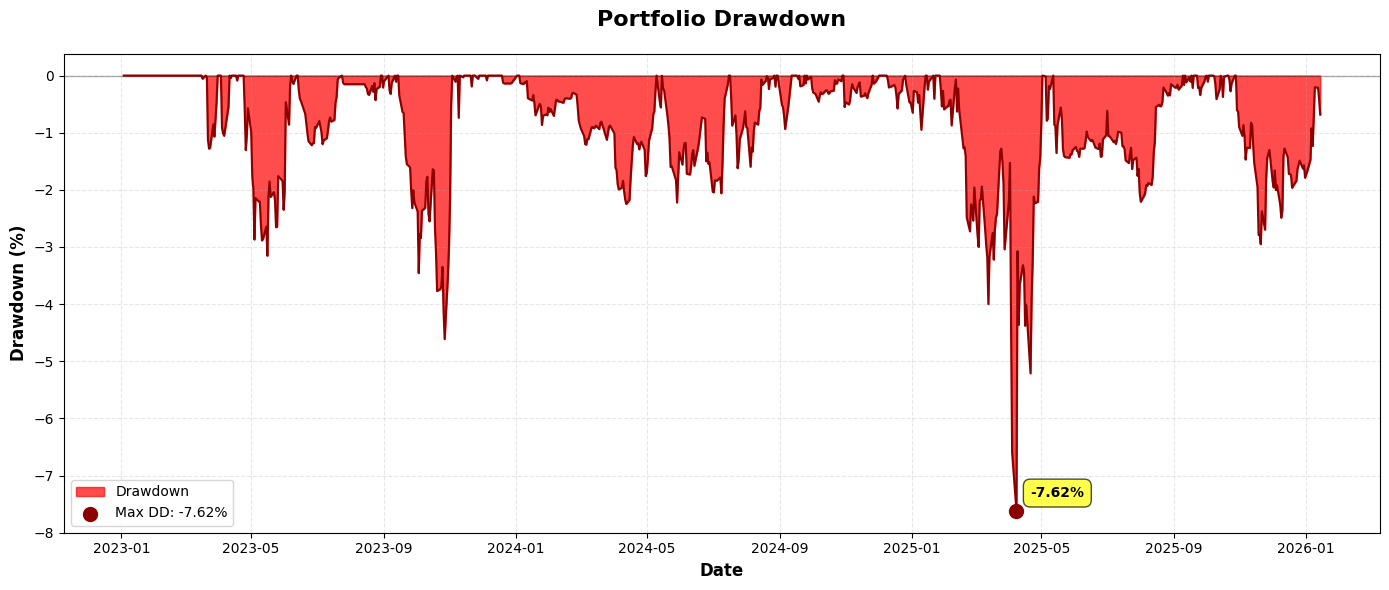

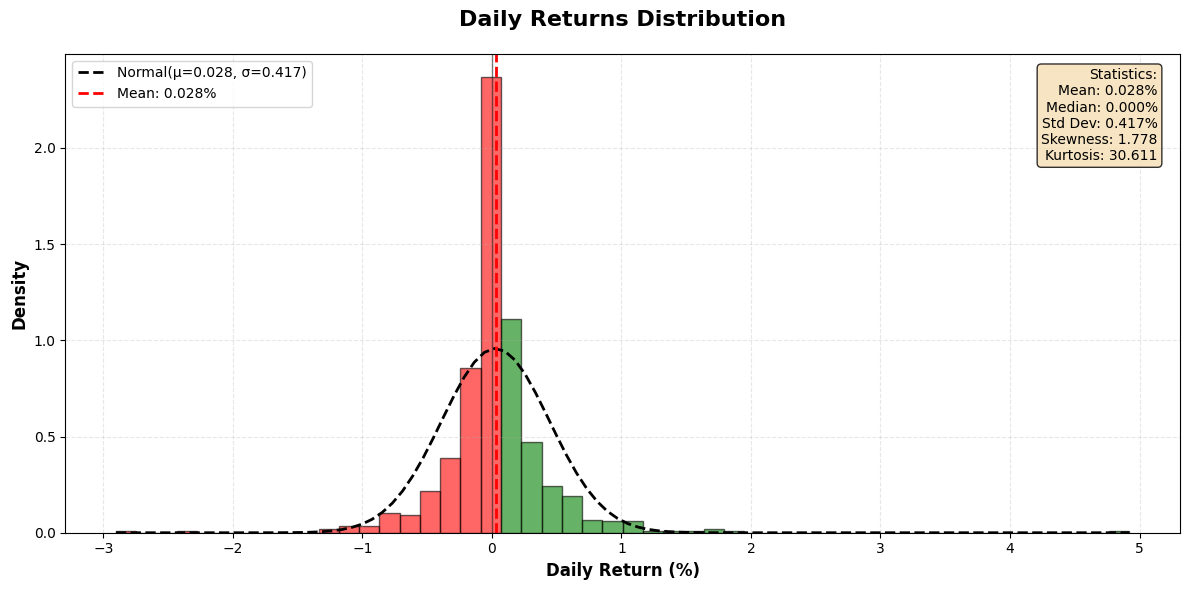

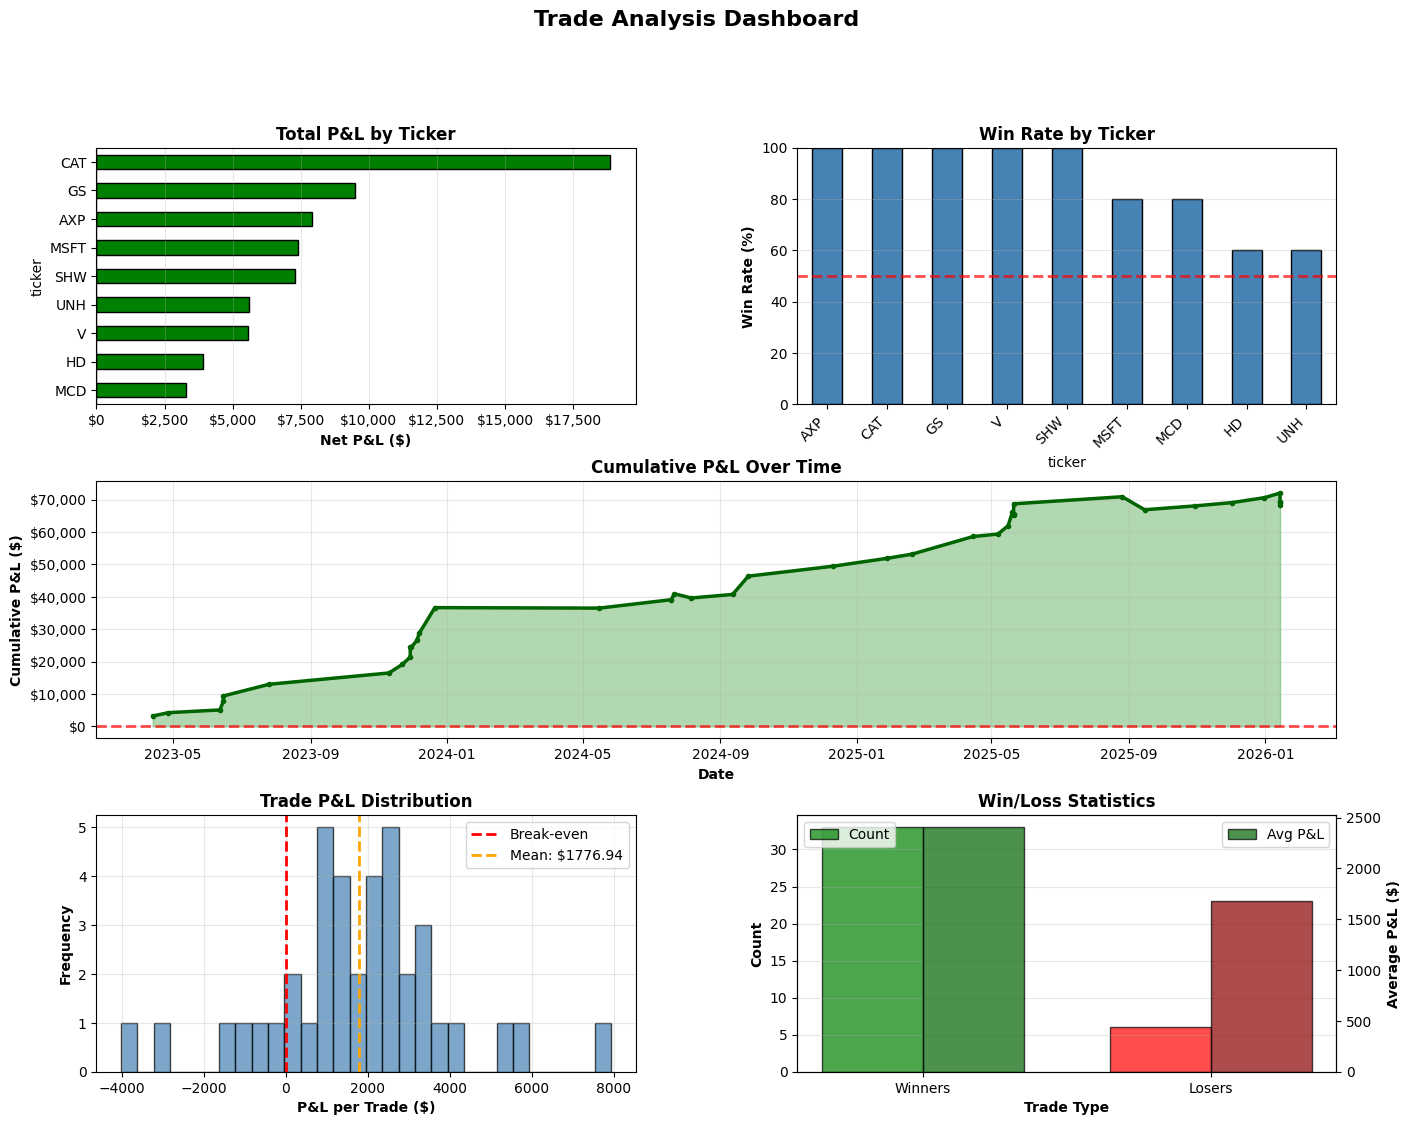

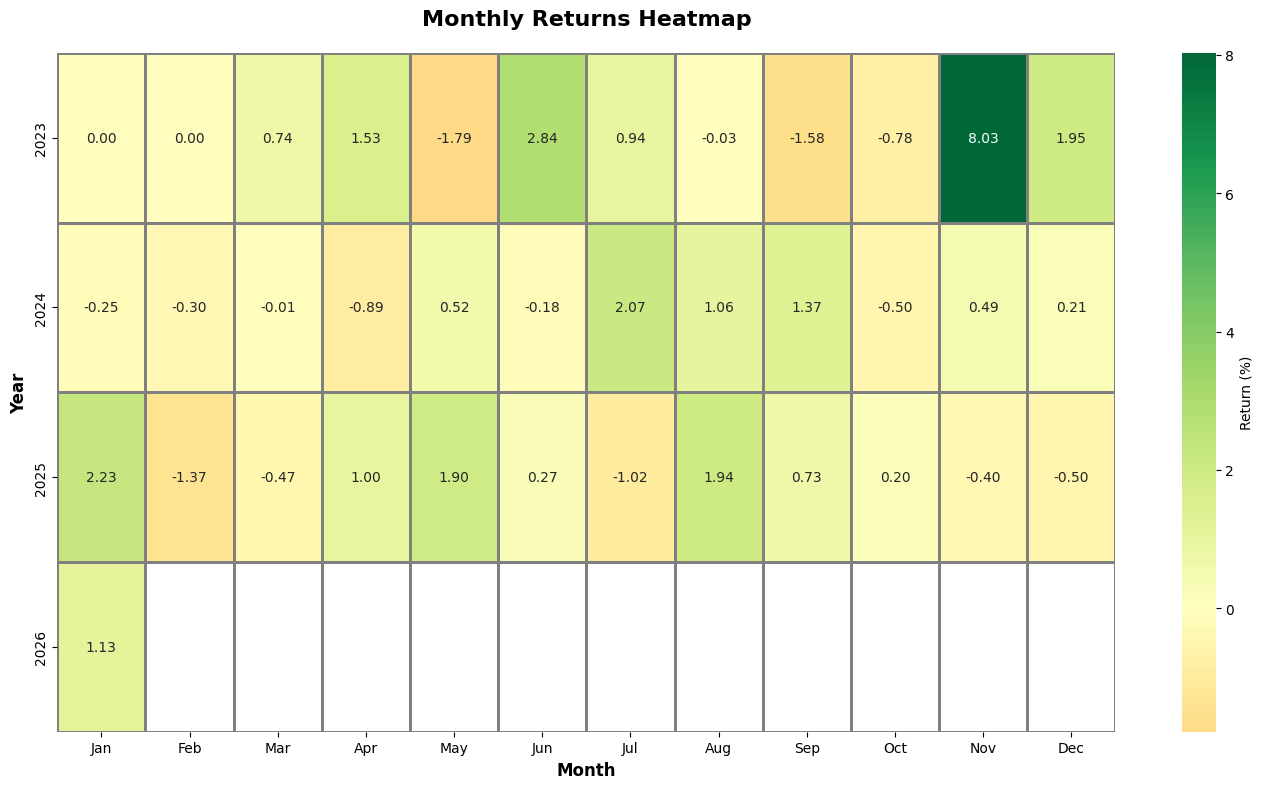

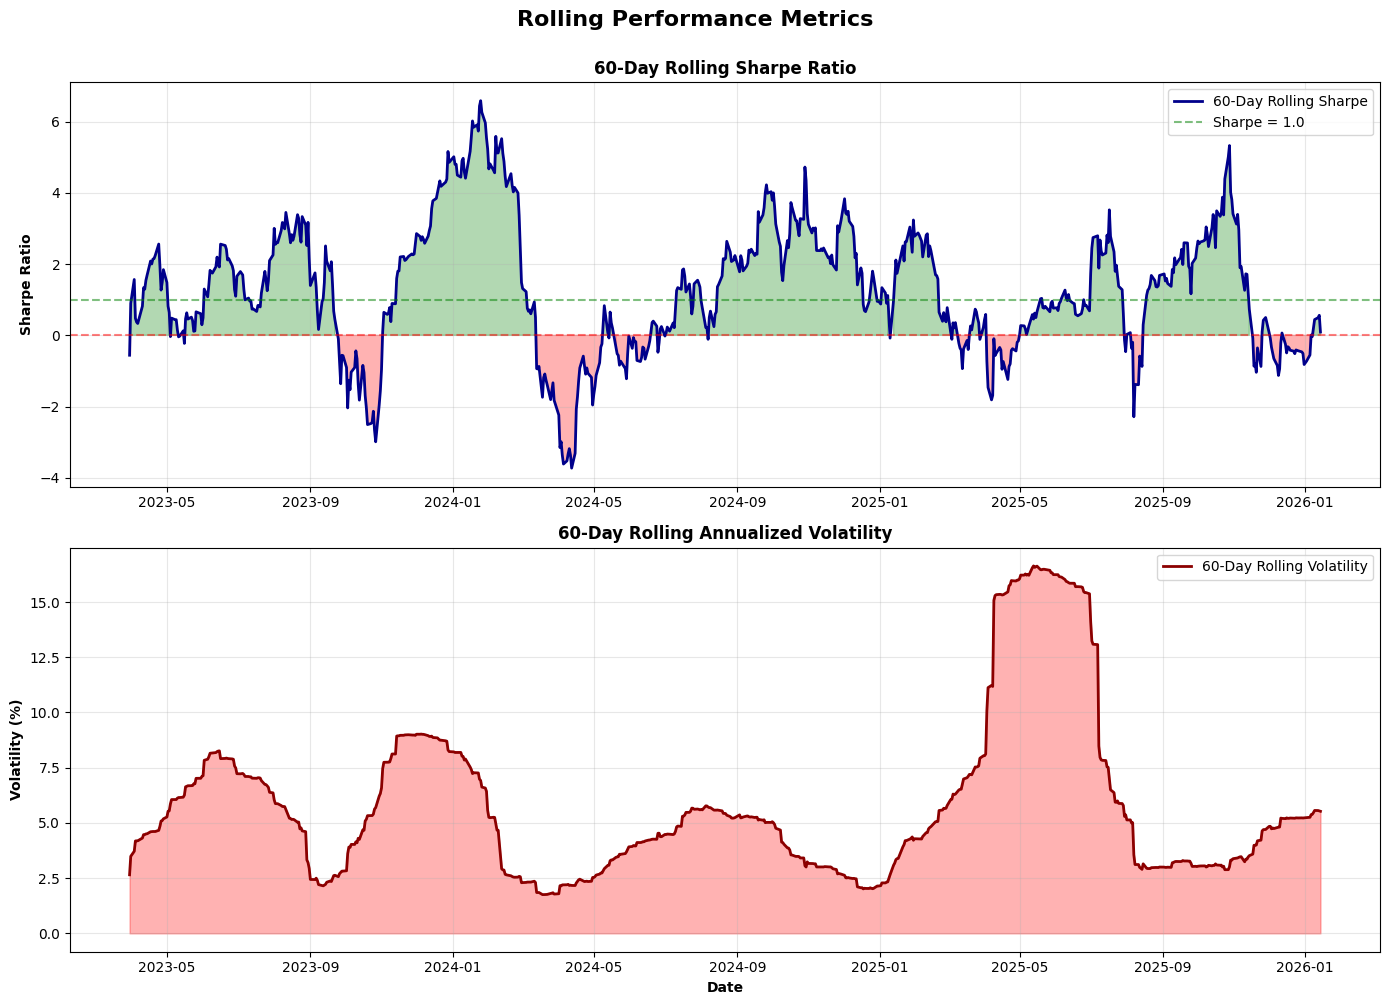

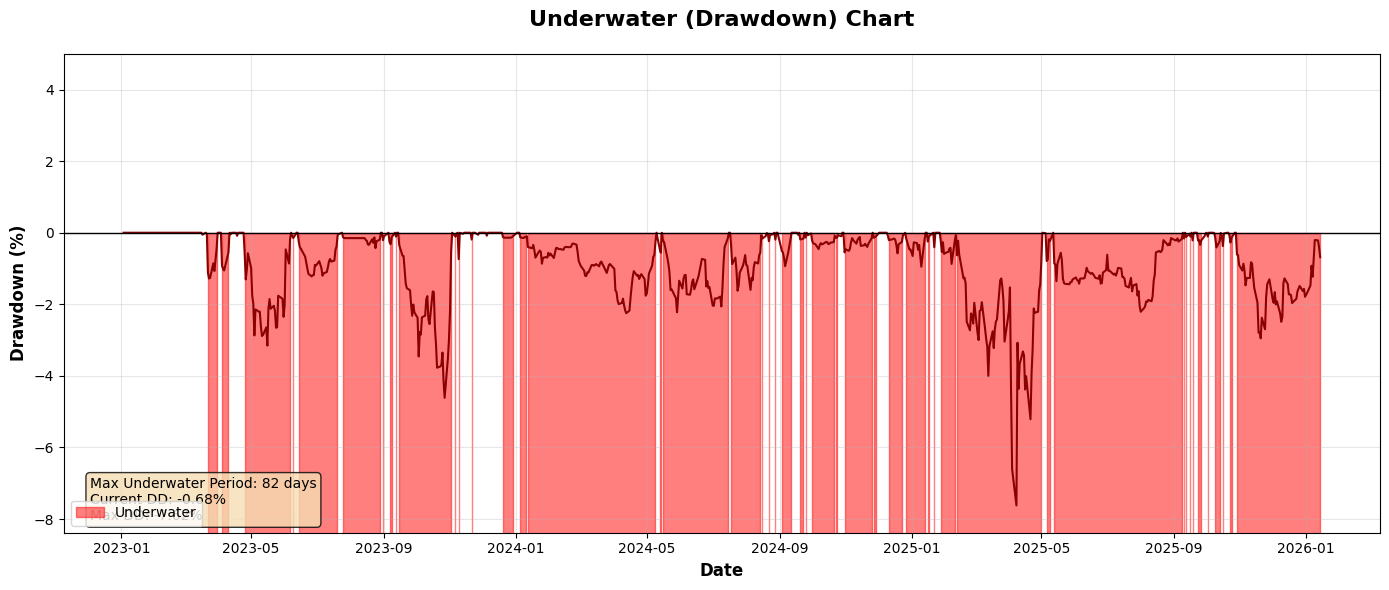

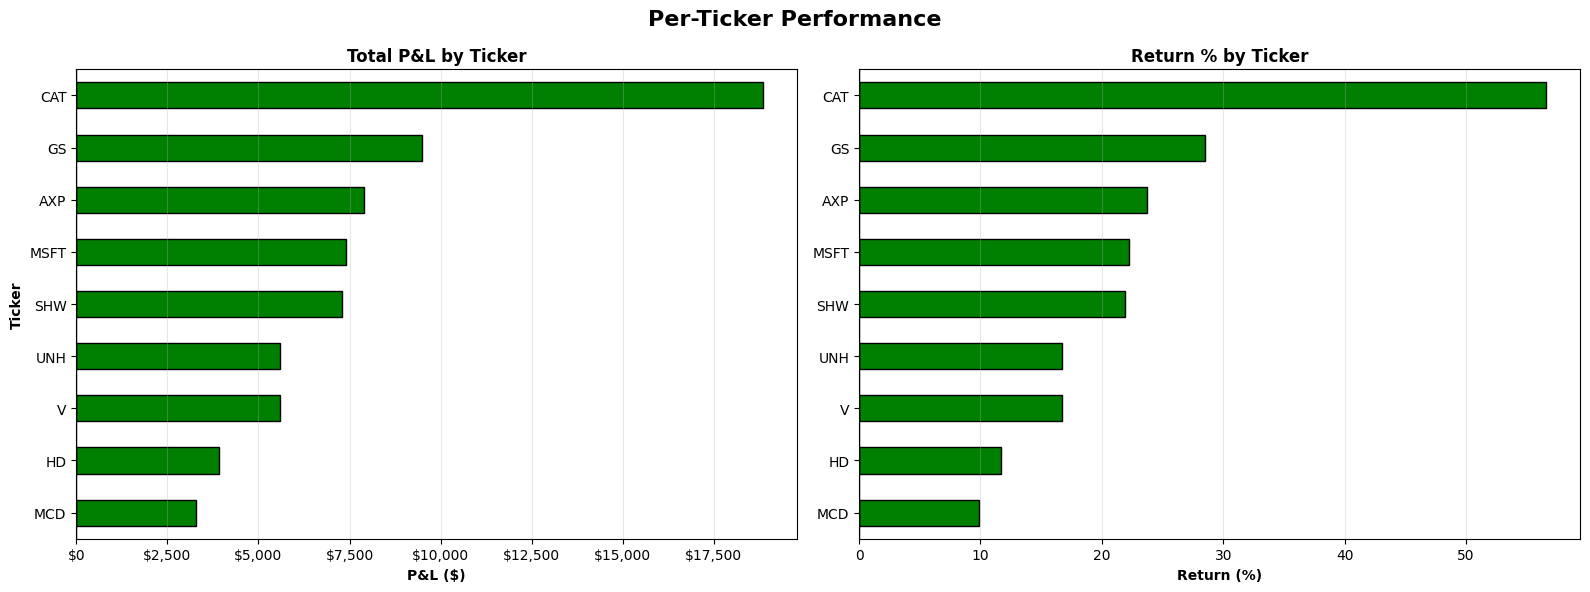

In [23]:
plot_performance_dashboard(results.portfolio_state, trade_config.initial_capital)

In [24]:
# Prepare data with indicators (SAVE THIS!)
prepared_data = {}
for ticker, df in aligned_data.items():
    prepared = strategy.prepare_data(df)
    prepared['ticker'] = ticker
    prepared_data[ticker] = prepared


SMI STRATEGY SIGNALS FOR UNH
Period: 2023-01-01 to 2025-12-31


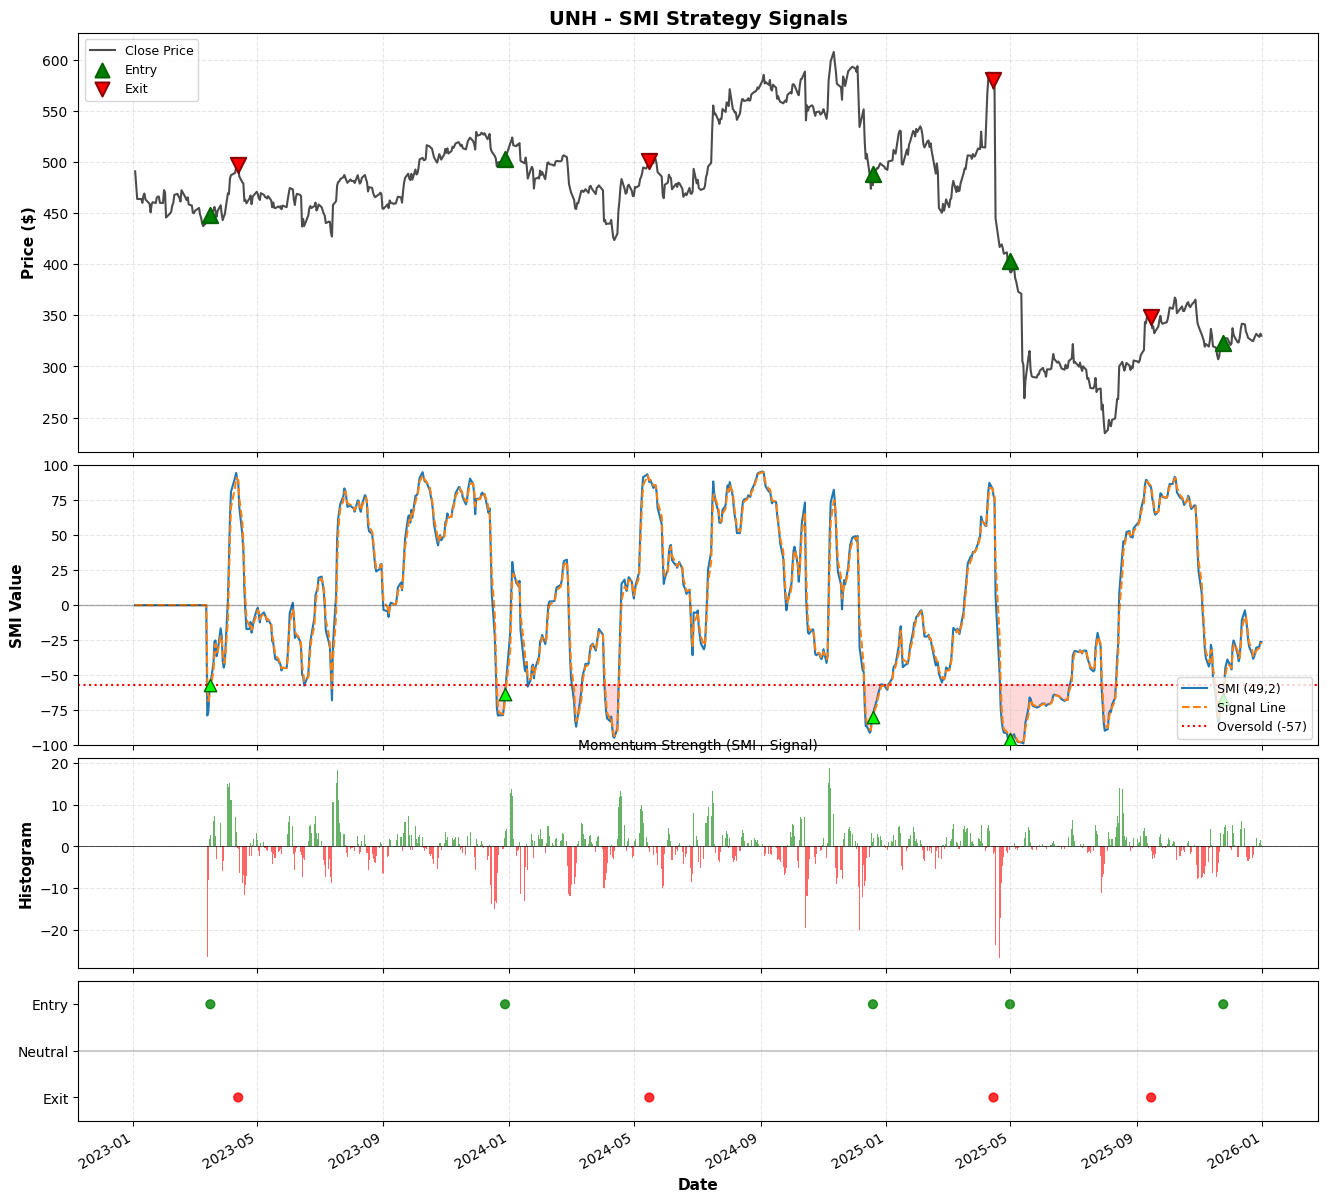


SMI Strategy Statistics for UNH:
--------------------------------------------------------------------------------
  Total Entry Signals: 5
  Total Exit Signals:  4

  Trade Performance:
    Total P&L: $4,514.92
    Wins: 2 | Losses: 2
    Win Rate: 50.0%
    Avg Win:  $4,339.14
    Avg Loss: $-2,081.68


In [25]:
plot_smi_signals(
    data=prepared_data['UNH'],
    ticker='UNH',
    results=results,
    start_date='2023-01-01',
    end_date='2025-12-31',
    strategy_config=strategy_config
)



SMI STRATEGY SIGNALS FOR GS
Period: 2023-01-01 to 2025-12-31


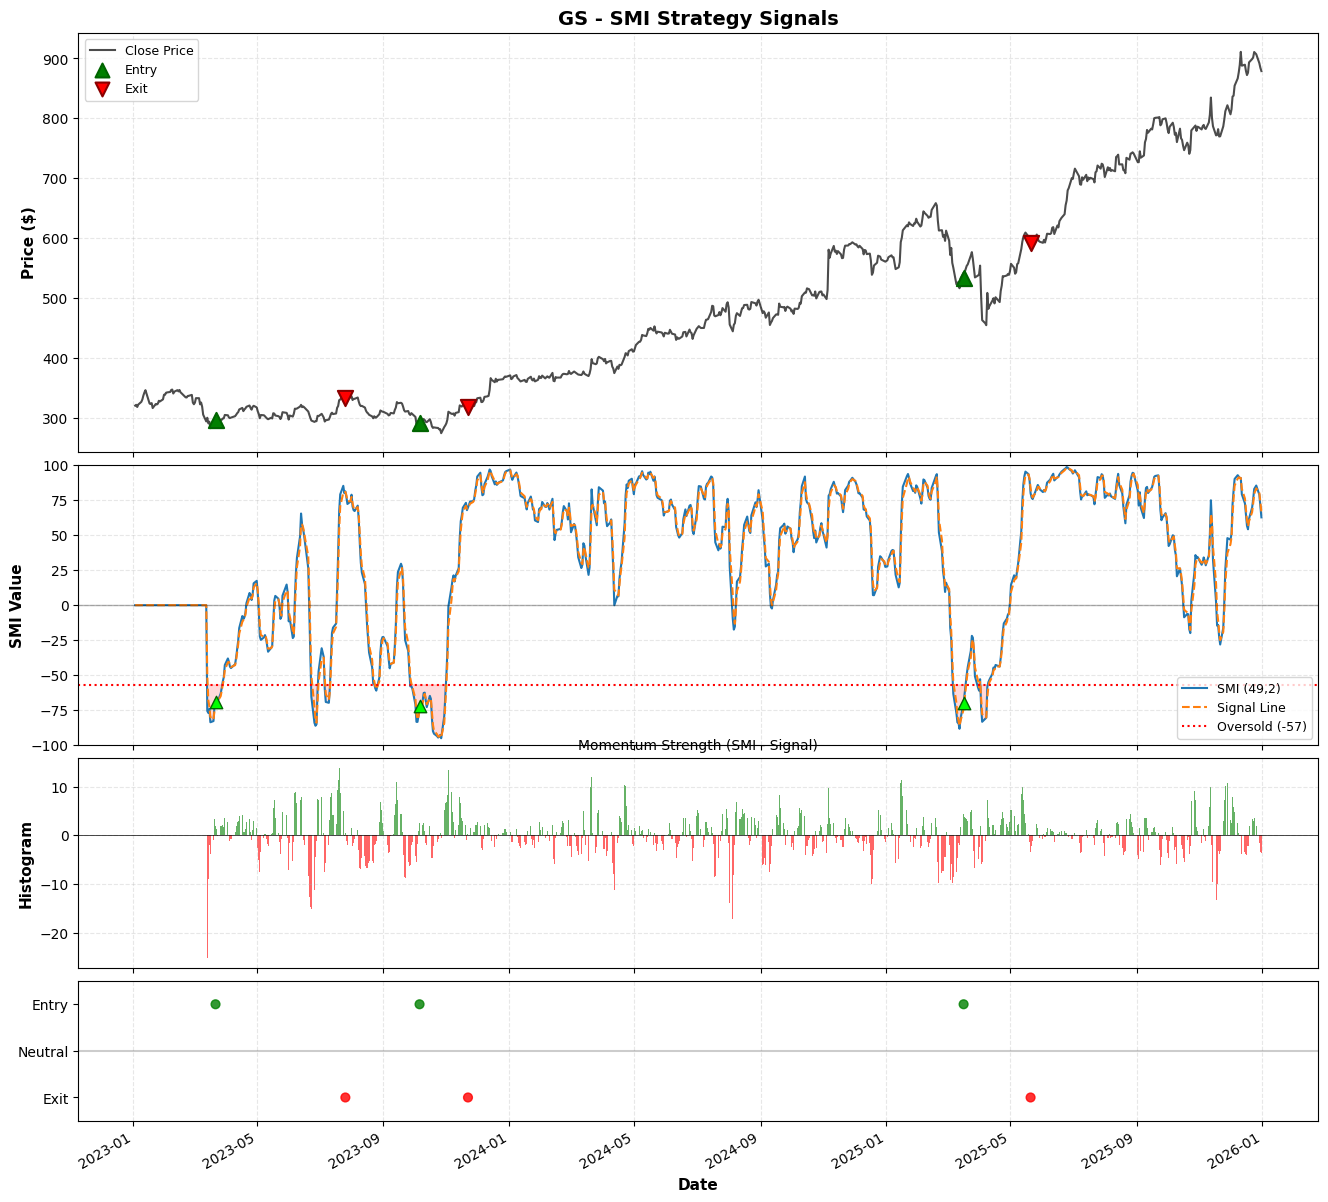


SMI Strategy Statistics for GS:
--------------------------------------------------------------------------------
  Total Entry Signals: 3
  Total Exit Signals:  3

  Trade Performance:
    Total P&L: $9,490.08
    Wins: 3 | Losses: 0
    Win Rate: 100.0%
    Avg Win:  $3,163.36

SMI STRATEGY SIGNALS FOR MSFT
Period: 2023-01-01 to 2025-12-31


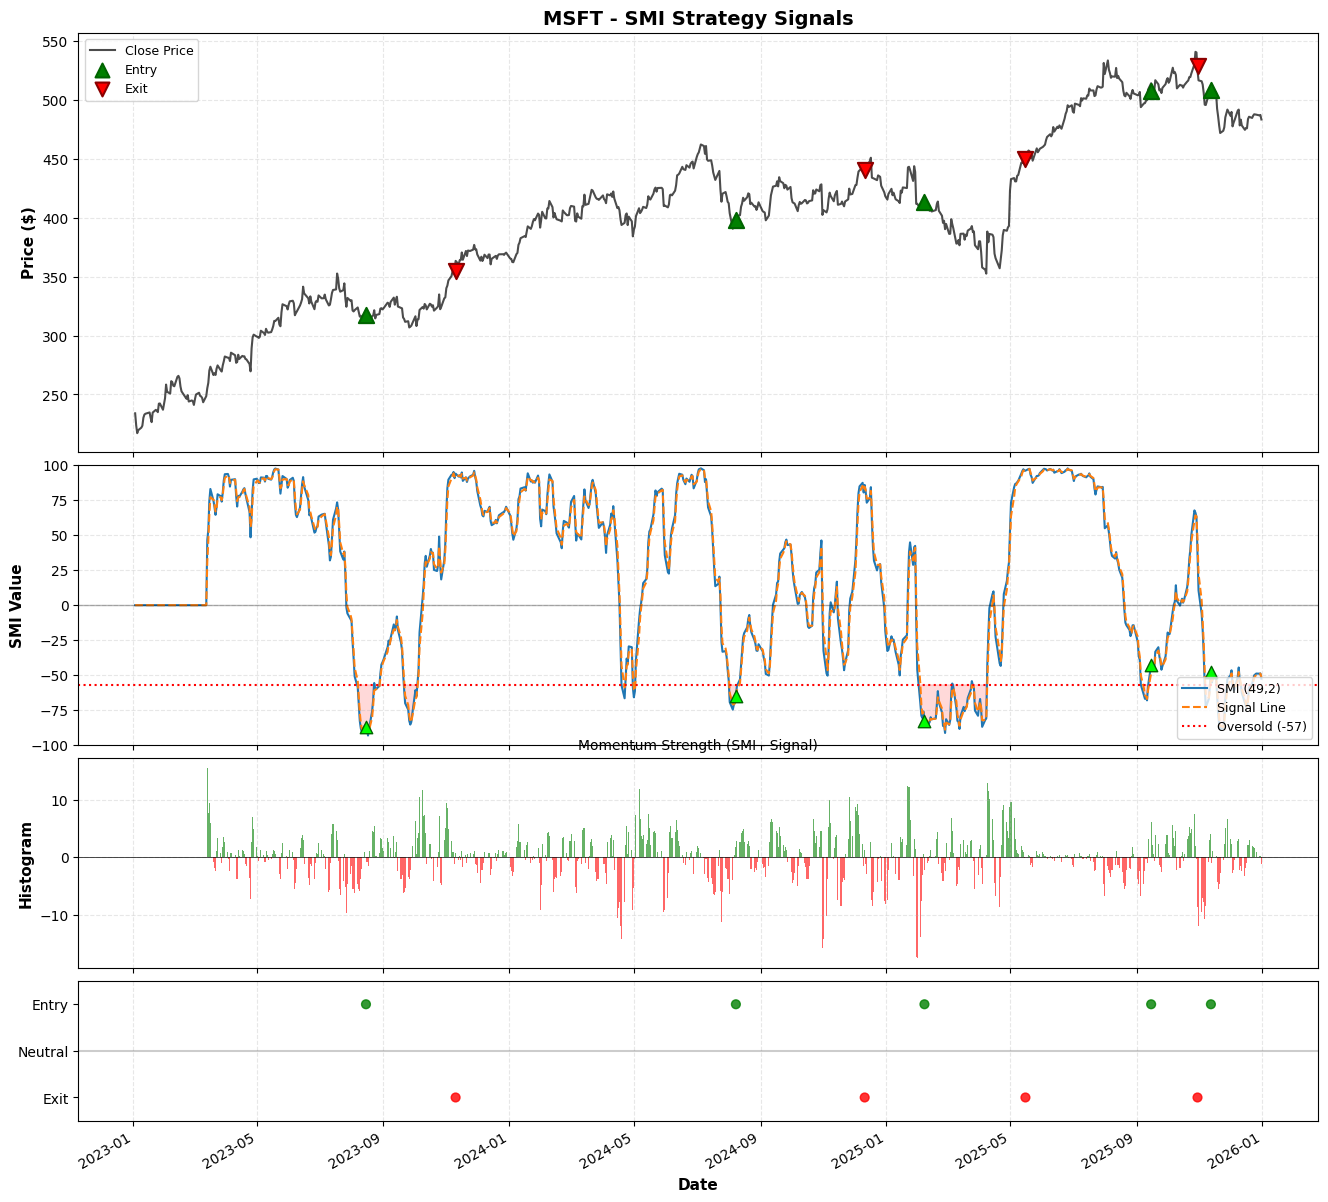


SMI Strategy Statistics for MSFT:
--------------------------------------------------------------------------------
  Total Entry Signals: 5
  Total Exit Signals:  4

  Trade Performance:
    Total P&L: $10,309.95
    Wins: 4 | Losses: 0
    Win Rate: 100.0%
    Avg Win:  $2,577.49

SMI STRATEGY SIGNALS FOR HD
Period: 2023-01-01 to 2025-12-31


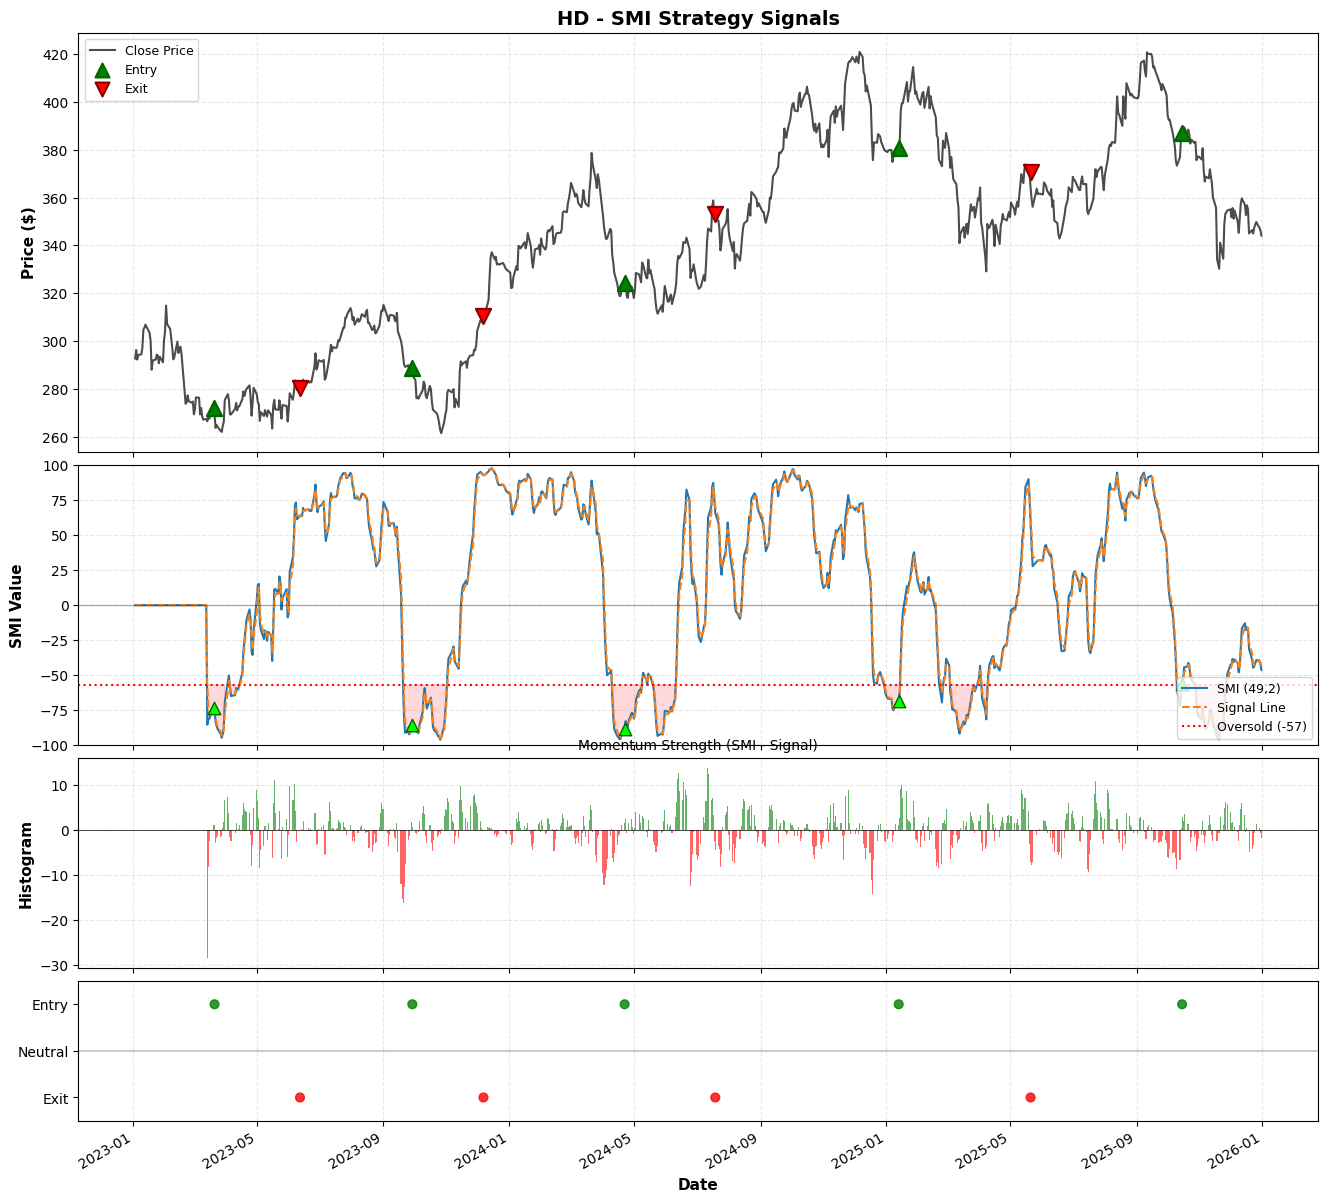


SMI Strategy Statistics for HD:
--------------------------------------------------------------------------------
  Total Entry Signals: 5
  Total Exit Signals:  4

  Trade Performance:
    Total P&L: $4,798.24
    Wins: 3 | Losses: 1
    Win Rate: 75.0%
    Avg Win:  $1,864.41
    Avg Loss: $-794.98

SMI STRATEGY SIGNALS FOR V
Period: 2023-01-01 to 2025-12-31


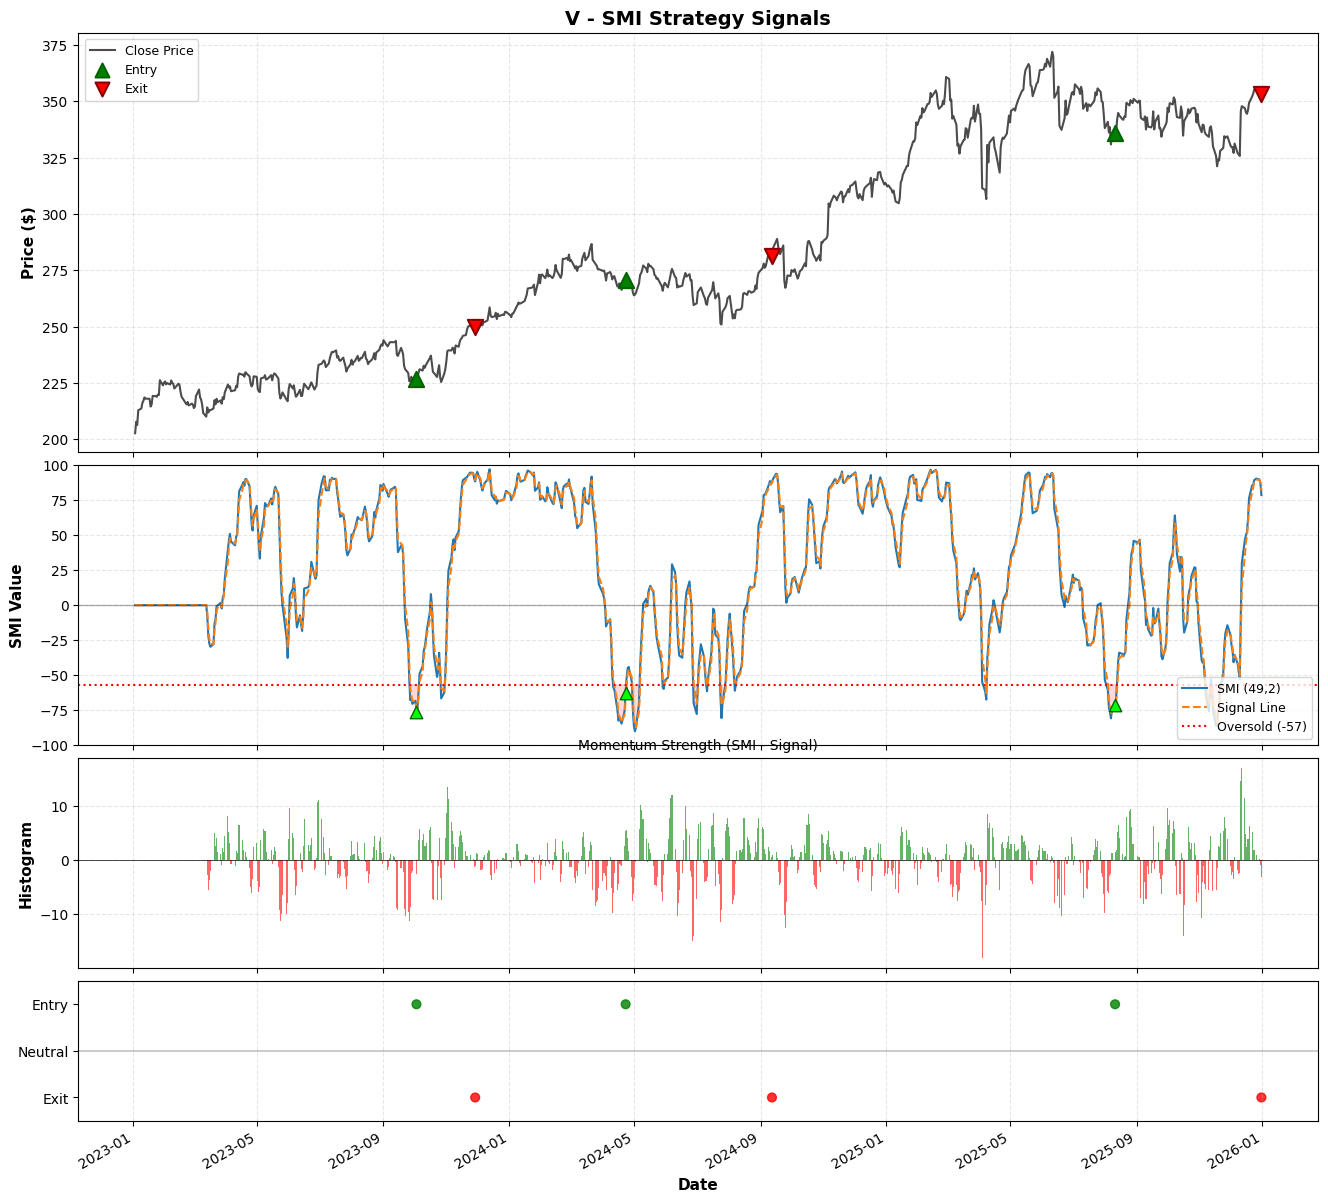


SMI Strategy Statistics for V:
--------------------------------------------------------------------------------
  Total Entry Signals: 3
  Total Exit Signals:  3

  Trade Performance:
    Total P&L: $5,583.10
    Wins: 3 | Losses: 0
    Win Rate: 100.0%
    Avg Win:  $1,861.03

SMI STRATEGY SIGNALS FOR SHW
Period: 2023-01-01 to 2025-12-31


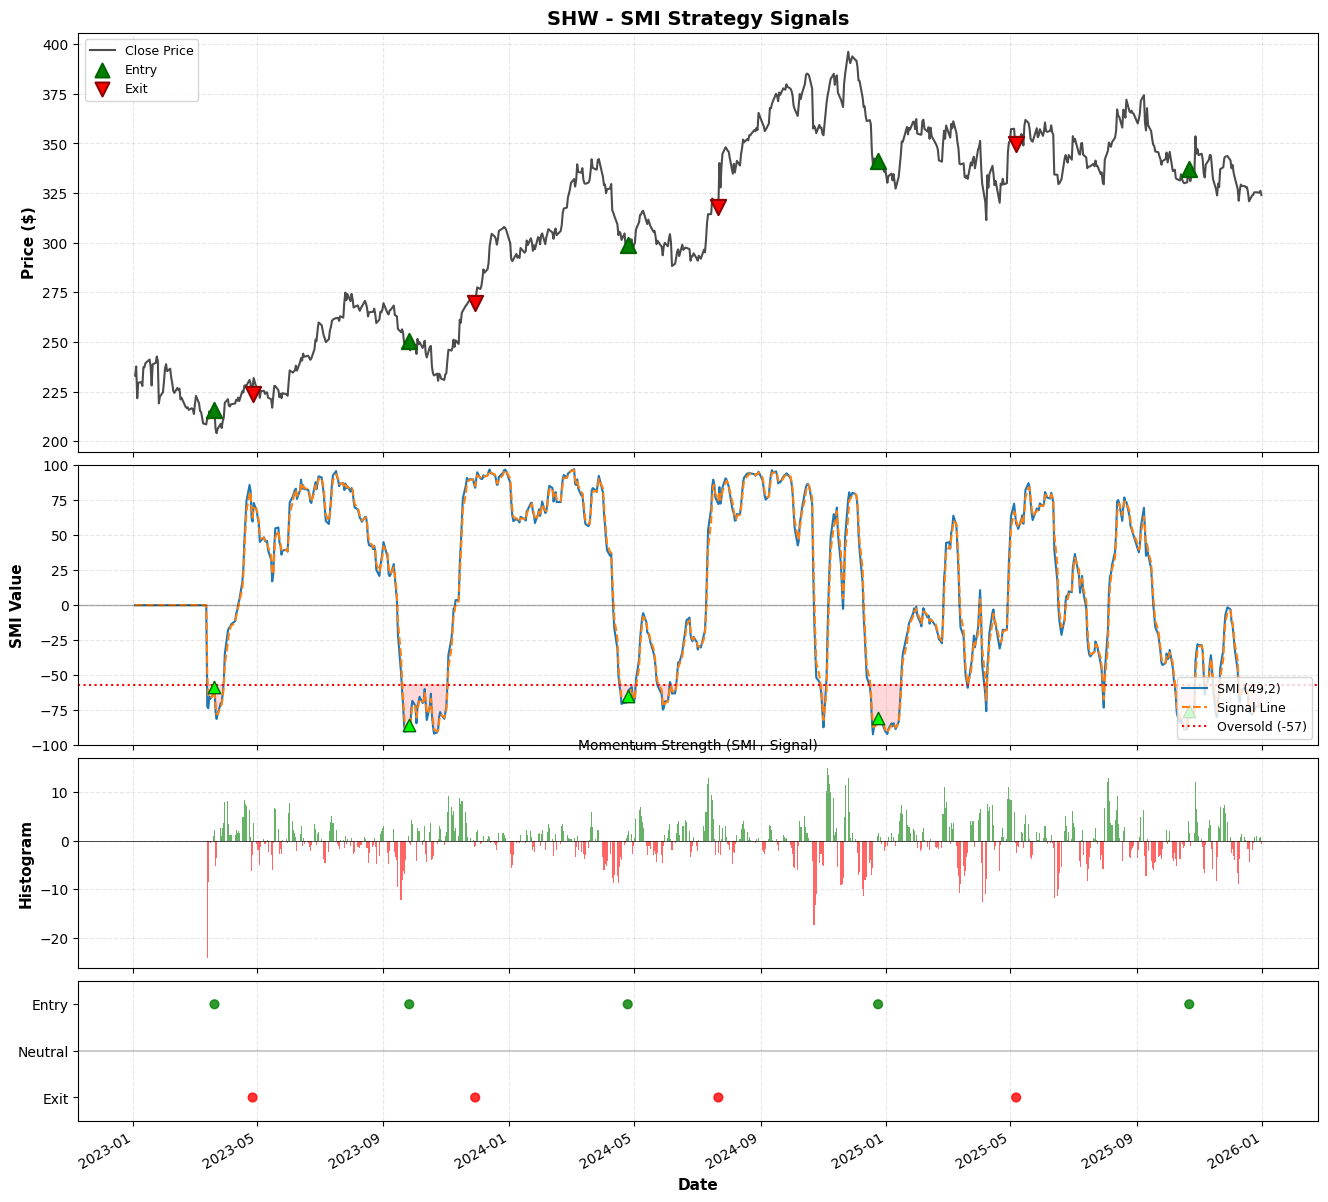


SMI Strategy Statistics for SHW:
--------------------------------------------------------------------------------
  Total Entry Signals: 5
  Total Exit Signals:  4

  Trade Performance:
    Total P&L: $5,855.76
    Wins: 4 | Losses: 0
    Win Rate: 100.0%
    Avg Win:  $1,463.94

SMI STRATEGY SIGNALS FOR CAT
Period: 2023-01-01 to 2025-12-31


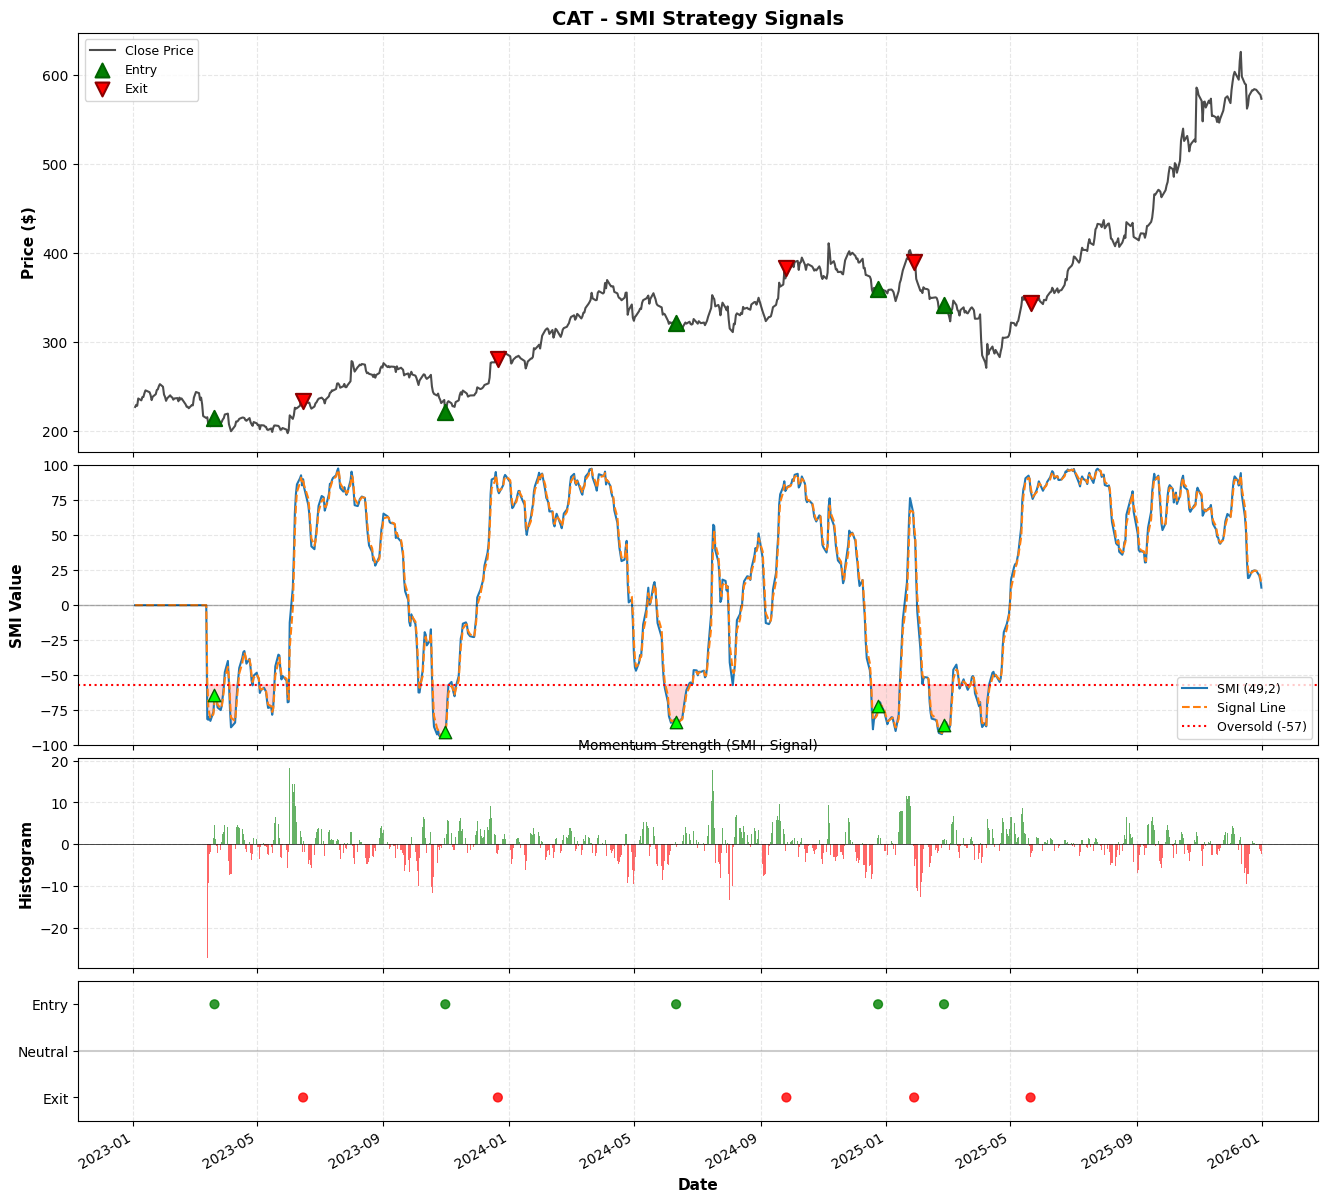


SMI Strategy Statistics for CAT:
--------------------------------------------------------------------------------
  Total Entry Signals: 5
  Total Exit Signals:  5

  Trade Performance:
    Total P&L: $18,848.40
    Wins: 5 | Losses: 0
    Win Rate: 100.0%
    Avg Win:  $3,769.68

SMI STRATEGY SIGNALS FOR MCD
Period: 2023-01-01 to 2025-12-31


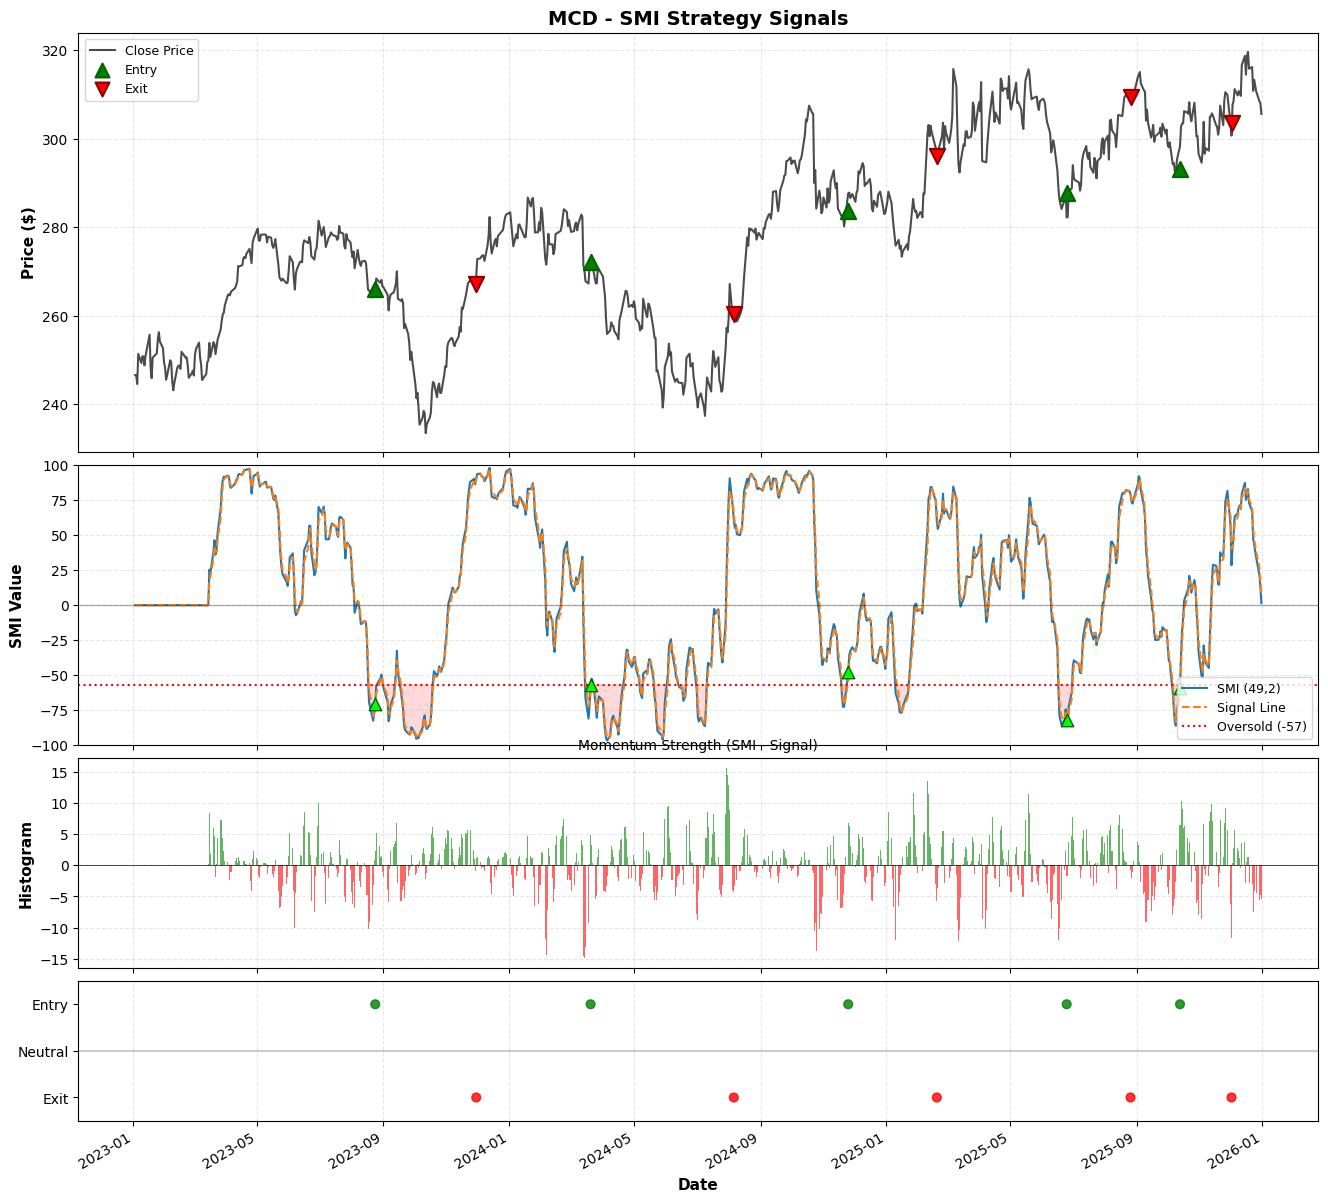


SMI Strategy Statistics for MCD:
--------------------------------------------------------------------------------
  Total Entry Signals: 5
  Total Exit Signals:  5

  Trade Performance:
    Total P&L: $3,281.61
    Wins: 4 | Losses: 1
    Win Rate: 80.0%
    Avg Win:  $1,148.10
    Avg Loss: $-1,310.81

SMI STRATEGY SIGNALS FOR UNH
Period: 2023-01-01 to 2025-12-31


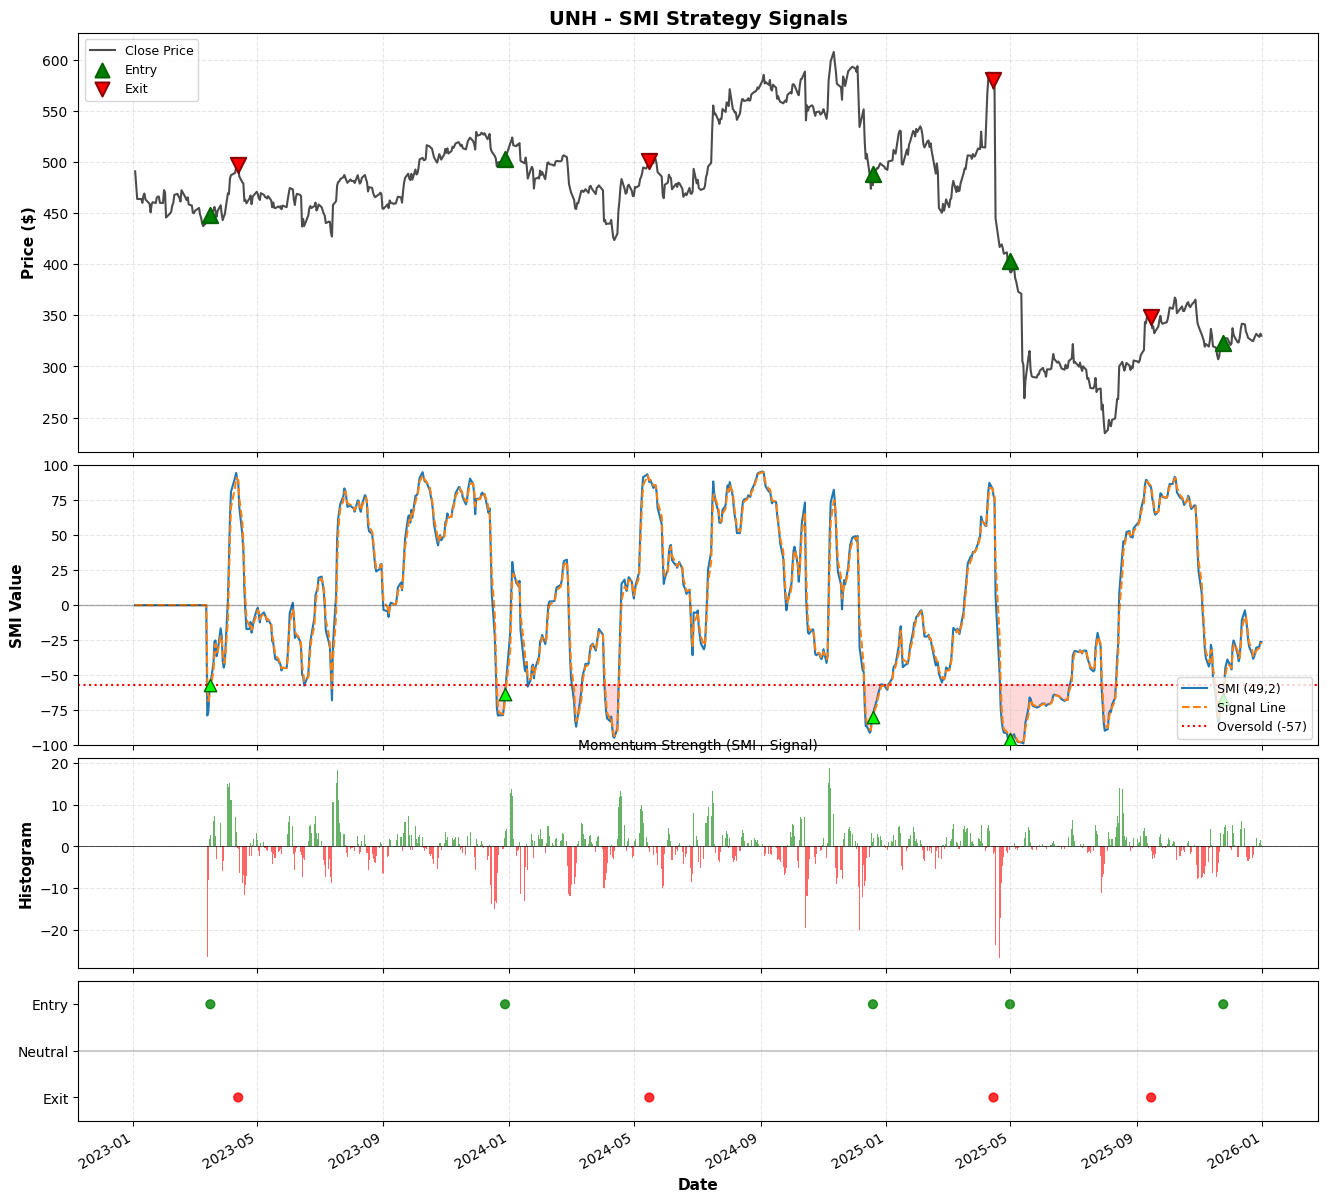


SMI Strategy Statistics for UNH:
--------------------------------------------------------------------------------
  Total Entry Signals: 5
  Total Exit Signals:  4

  Trade Performance:
    Total P&L: $4,514.92
    Wins: 2 | Losses: 2
    Win Rate: 50.0%
    Avg Win:  $4,339.14
    Avg Loss: $-2,081.68

SMI STRATEGY SIGNALS FOR AXP
Period: 2023-01-01 to 2025-12-31


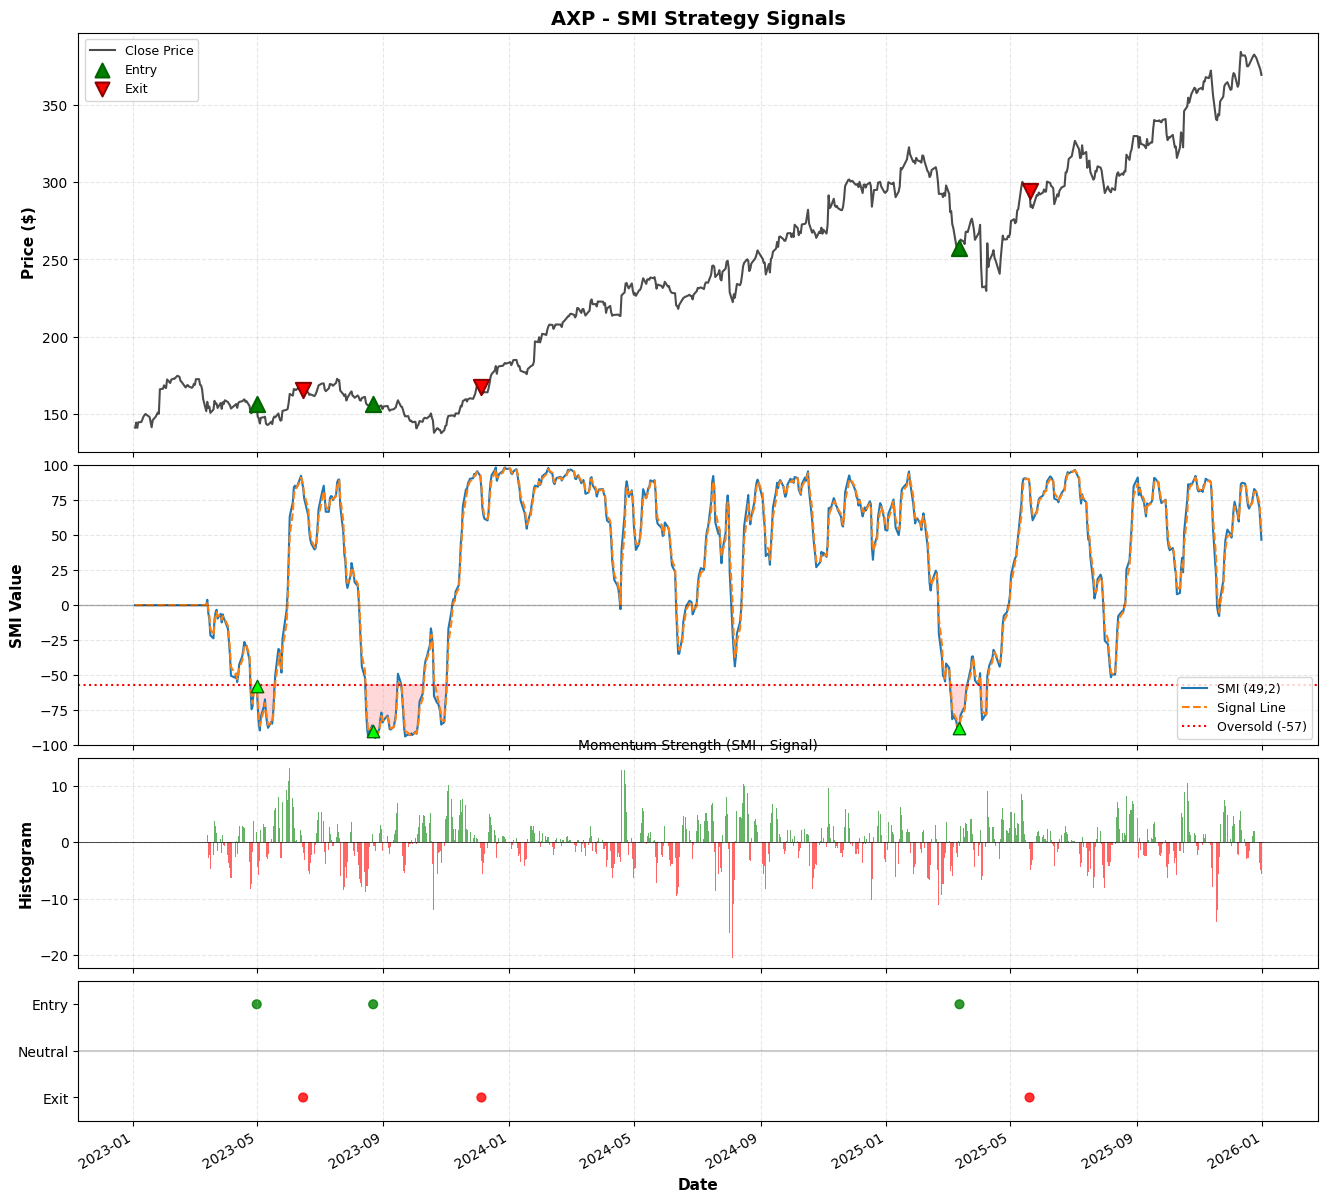


SMI Strategy Statistics for AXP:
--------------------------------------------------------------------------------
  Total Entry Signals: 3
  Total Exit Signals:  3

  Trade Performance:
    Total P&L: $7,898.03
    Wins: 3 | Losses: 0
    Win Rate: 100.0%
    Avg Win:  $2,632.68


In [26]:
for ticker in prepared_data.keys():
    plot_smi_signals(
        data=prepared_data[ticker],
        ticker=ticker,
        results=results,
        start_date='2023-01-01',
        end_date='2025-12-31',
        strategy_config=strategy_config
    )
